# Уже было

In [1]:
import json
import numpy as np
import statistics
import os
import csv
import pandas as pd

In [2]:
def data_preparation(data):
    widthList = []
    heightList = []
    lengthList = []
    volumeList = []
    countStacking = 0
    countTurnover = 0
    boxesCount = 0
    for x in data['data_result']['boxes']:
        widthList.append(x['size']['width'])
        heightList.append(x['size']['height'])
        lengthList.append(x['size']['length'])
        volumeList.append(x['size']['width']*x['size']['height']*x['size']['length'])
        if x['stacking'] == True:
            countStacking += 1
        if x['turnover'] == True:
            countTurnover += 1
        boxesCount += 1
    meanWidth = statistics.mean(widthList)
    meanHeight = statistics.mean(heightList)
    meanLength = statistics.mean(lengthList)
    meanVolume = statistics.mean(volumeList)

    loadingWidth = data['data_result']['cargo_space']['loading_size']['width']
    loadingHeight = data['data_result']['cargo_space']['loading_size']['height']
    loadingLength = data['data_result']['cargo_space']['loading_size']['length']

    density_percent = data['data_result']['cargo_space']['calculation_info']['density_percent']

    values = [meanWidth, meanHeight, meanLength, meanVolume, countStacking,
              countTurnover, boxesCount, loadingWidth, loadingHeight,
              loadingLength, density_percent]
    
    return values

In [3]:
def write_to_csv(param):
  field = ['meanWidth','meanHeight','meanLength','meanVolume','countStacking',
           'countTurnover', 'boxesCount', 'loadingWidth', 'loadingHeight',
           'loadingLength', 'density_percent']
  filename = 'data.csv'
  with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(field)
    writer.writerows(param)

In [4]:
folder_path = 'ALGORITM/'

file_list = os.listdir(folder_path)

param = []

for file_name in file_list:
    # Проверяем, что файл имеет расширение .json
    if file_name.endswith('.json'):
        # Формируем полный путь к файлу
        file_path = os.path.join(folder_path, file_name)
        
        # Открываем файл и читаем его содержимое
        jsonFile = open(file_path, 'r', encoding='utf-8')
        # Загружаем JSON-данные
        data = json.load(jsonFile)
        new_row = data_preparation(data)
        param.append(new_row)
        jsonFile.close()


FileNotFoundError: [WinError 3] Системе не удается найти указанный путь: 'ALGORITM/'

In [61]:
#запись в файл csv
write_to_csv(param)

# Пробуем нейронку

In [54]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
warnings.filterwarnings('ignore')

In [72]:
class TableDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

df = pd.read_csv('data.csv') 

features = df[df.columns[:-1]]
targets = df[df.columns[-1]]

features = (features - features.mean()) / features.std()

features_train, features_val, targets_train, targets_val = train_test_split(features, targets, test_size=0.2)

features_train = torch.tensor(features_train.values, dtype=torch.float32)
targets_train = torch.tensor(targets_train.values, dtype=torch.float32)

features_val = torch.tensor(features_val.values, dtype=torch.float32)
targets_val = torch.tensor(targets_val.values, dtype=torch.float32)

train_dataset = TableDataset(features_train, targets_train)
val_dataset = TableDataset(features_val, targets_val)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}


In [73]:
class RegressionNet(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNet, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(32)
        
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.batch_norm1(x)
        x = self.dropout(x)
        
        x = F.relu(self.layer2(x))
        x = self.batch_norm2(x)
        x = self.dropout(x)

        x = self.layer3(x)
        return x

In [67]:
device = "cpu"
num_epochs = 120

In [74]:
from math import sqrt

# Инициализация модели, оптимизатора и функции потерь
model = RegressionNet(input_dim=10)
model = model.to(device)  # Если вы используете GPU

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
mse_criterion = nn.MSELoss()
mae_criterion = nn.L1Loss()

for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_mse_loss = 0.0
        running_mae_loss = 0.0

        for i, (features, targets) in enumerate(dataloaders[phase]):
            features = features.to(device)
            targets = targets.to(device)
        
            # Forward pass
            outputs = model(features)
            
            # Calculate loss
            mse_loss = mse_criterion(outputs, targets)
            mae_loss = mae_criterion(outputs, targets)
            
            if phase == 'train':
                # Backward and optimize
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()
        
            running_mse_loss += mse_loss.item()
            running_mae_loss += mae_loss.item()
        
        epoch_mse_loss = running_mse_loss / len(dataloaders[phase])
        epoch_mae_loss = running_mae_loss / len(dataloaders[phase])
        epoch_rmse_loss = sqrt(epoch_mse_loss)

        print(f'{phase} Loss MSE: {epoch_mse_loss:.4f}, RMSE: {epoch_rmse_loss:.4f}, MAE: {epoch_mae_loss:.4f}')
    print('-' * 10)


train Loss MSE: 6083.5365, RMSE: 77.9970, MAE: 75.7841
val Loss MSE: 6218.7180, RMSE: 78.8588, MAE: 76.9303
----------
train Loss MSE: 6039.8526, RMSE: 77.7165, MAE: 75.5026
val Loss MSE: 6142.4205, RMSE: 78.3736, MAE: 76.4330
----------
train Loss MSE: 5962.0481, RMSE: 77.2143, MAE: 74.9835
val Loss MSE: 6046.0091, RMSE: 77.7561, MAE: 75.8021
----------
train Loss MSE: 5817.0972, RMSE: 76.2699, MAE: 74.0030
val Loss MSE: 5810.5299, RMSE: 76.2268, MAE: 74.2175
----------
train Loss MSE: 5582.5113, RMSE: 74.7162, MAE: 72.3832
val Loss MSE: 5511.1446, RMSE: 74.2371, MAE: 72.1561
----------
train Loss MSE: 5280.0522, RMSE: 72.6640, MAE: 70.2634
val Loss MSE: 5196.4891, RMSE: 72.0867, MAE: 69.9484
----------
train Loss MSE: 4889.2966, RMSE: 69.9235, MAE: 67.3854
val Loss MSE: 4800.3162, RMSE: 69.2843, MAE: 67.0783
----------
train Loss MSE: 4447.3522, RMSE: 66.6885, MAE: 64.0502
val Loss MSE: 4307.0031, RMSE: 65.6278, MAE: 63.2921
----------
train Loss MSE: 3979.6893, RMSE: 63.0848, MAE: 6

In [78]:
# MSE: 305.6176, RMSE: 17.4819, MAE: 14.5559

# Пробуем catboost (туториалы наше все)

In [33]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

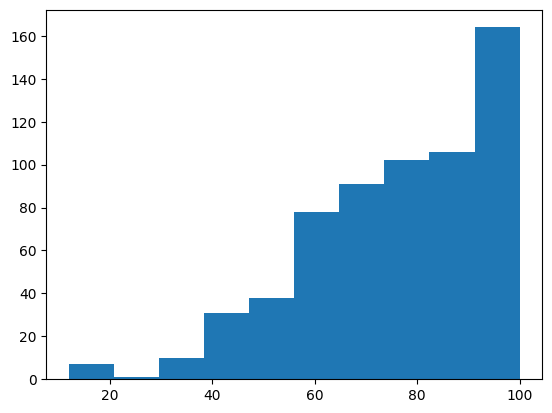

In [76]:
%matplotlib inline
plt.hist(y);

In [19]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

In [11]:
y = df[['density_percent']]
X = df.drop(['density_percent'], axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, shuffle=True, train_size=0.7)

In [77]:
model = CatBoostRegressor(random_state=42, iterations=700, verbose=250)
# model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_valid)
print('-'*80)
print('MAE: ', mean_absolute_error(y_valid, predictions))
print('MSE: ', mean_squared_error(y_valid, predictions))
print('RMSE: ', np.sqrt(mean_squared_error(y_valid, predictions)))

Learning rate set to 0.048042
0:	learn: 17.8066625	total: 38.9ms	remaining: 27.2s
250:	learn: 7.6159134	total: 446ms	remaining: 798ms
500:	learn: 4.6055732	total: 797ms	remaining: 317ms
699:	learn: 3.3580994	total: 1.09s	remaining: 0us
----------------------------------------------------------------------------------------------------
MAE:  8.226972030473817
MSE:  156.41024458238994
RMSE:  12.506408140724895


In [ ]:
# MAE:  8.226972030473817
# MSE:  156.41024458238994
# RMSE:  12.506408140724895